# Mesh generation and visualization 
*Authors: Corrado Maurini (corrado.maurini@sorbonne-universite.fr)*

In this notebook you will find examples to
 - Generate meshes with `gmsh` and import them in `dolfinx`
 - Visualize the `dolfinx` mesh directly in the notebook using `pyvista`
 - Save the mesh to an `xmdf` file

We consider an elastic slab $\Omega$ with a straight crack $\Gamma$ 
Using the symmetry, we will consider only half of the domain in the computation and we refine the mesh around the crack tip.

![title](../01-Linear-Elasticity/domain.png)


Let us generate a mesh using gmsh (http://gmsh.info/). 

The function to generate the mesh is reported in the external file `meshes.py`. 
The mesh is refined around the crack tip.

In [1]:
import gmsh
import numpy as np
from mpi4py import MPI
from dolfinx.io import gmshio, XDMFFile
import dolfinx.plot

We define below the geometrical paramters of the mesh.

In [2]:
Lx = 1.
Ly = .5
Lcrack = 0.3
lc = 0.1
dist_min = .1
dist_max = .3
refinement_ratio = 10
gdim = 2


The following code block generate the mesh using the `gmsh` python interface. We refer the reader to the `gmsh` documentation for details: https://gmsh.info/doc/texinfo/gmsh.html

We also define *MPI communicator*s, which are required only in parallel computation.
They are not stricly necessary here, but we keep them to have this example working in general. 
The are set so that when we perform parallel computations, the mesh is generated on one processor (`model_rank=0`) and then it is distributed to all the processors (`mesh_comm = MPI.COMM_WORLD`) 

We define a dictionary `tags` to associate clear names to numerical tags that are used to identify the different part of the domain and the boundary

In [3]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0
gmsh.initialize()

facet_tags = {"left": 1, "right": 2, "top": 3, "crack": 4, "bottom_no_crack": 5}
cell_tags = {"all": 20}

if mesh_comm.rank == model_rank:
    model = gmsh.model()
    model.add("Rectangle")
    model.setCurrent("Rectangle")
    # Create the points
    p1 = model.geo.addPoint(0.0, 0.0, 0, lc)
    p2 = model.geo.addPoint(Lcrack, 0.0, 0, lc)
    p3 = model.geo.addPoint(Lx, 0, 0, lc)
    p4 = model.geo.addPoint(Lx, Ly, 0, lc)
    p5 = model.geo.addPoint(0, Ly, 0, lc)
    # Create the lines
    l1 = model.geo.addLine(p1, p2, tag=facet_tags["crack"])
    l2 = model.geo.addLine(p2, p3, tag=facet_tags["bottom_no_crack"])
    l3 = model.geo.addLine(p3, p4, tag=facet_tags["right"])
    l4 = model.geo.addLine(p4, p5, tag=facet_tags["top"])
    l5 = model.geo.addLine(p5, p1, tag=facet_tags["left"])
    # Create the surface
    cloop1 = model.geo.addCurveLoop([l1, l2, l3, l4, l5])
    surface_1 = model.geo.addPlaneSurface([cloop1])
    
    # Define the mesh size and fields for the mesh refinement
    model.mesh.field.add("Distance", 1)
    model.mesh.field.setNumbers(1, "NodesList", [p2])
    # SizeMax -                   / ------------------
    #                            /
    # SizeMin -o----------------/
    #          |                |  |
    #        Point        DistMin   DistMax
    model.mesh.field.add("Threshold", 2)
    model.mesh.field.setNumber(2, "IField", 1)
    model.mesh.field.setNumber(2, "LcMin", lc / refinement_ratio)
    model.mesh.field.setNumber(2, "LcMax", lc)
    model.mesh.field.setNumber(2, "DistMin", dist_min)
    model.mesh.field.setNumber(2, "DistMax", dist_max)
    model.mesh.field.setAsBackgroundMesh(2)
    model.geo.synchronize()
    
    # Assign mesh and facet tags
    surface_entities = [entity[1] for entity in model.getEntities(2)]
    model.addPhysicalGroup(2, surface_entities, tag=cell_tags["all"])
    model.setPhysicalName(2, 2, "Rectangle surface")
    model.mesh.generate(gdim)
    
    for (key,value) in facet_tags.items():
        model.addPhysicalGroup(1, [value], tag=value)
        model.setPhysicalName(1, value, key)
    


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00229633s, CPU 0.002372s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00660221s, CPU 0.006509s)
Info    : 413 nodes 829 elements


We can now import the mesh in `dolfinx`

In [4]:
msh, cell_tags, facet_tags = gmshio.model_to_mesh(model, mesh_comm, model_rank, gdim=gdim)
msh.naame = "rectangle"
cell_tags.name = f"{msh.name}_cells"
facet_tags.name = f"{msh.name}_facets"


In [5]:

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/mesh.xdmf", "w") as file:
    file.write_mesh(msh)
    msh.topology.create_connectivity(1, 2)
    file.write_meshtags(cell_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")
    file.write_meshtags(facet_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")


To plot the mesh we use `pyvista` see:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/main/python/demos/pyvista/demo_pyvista.py.html

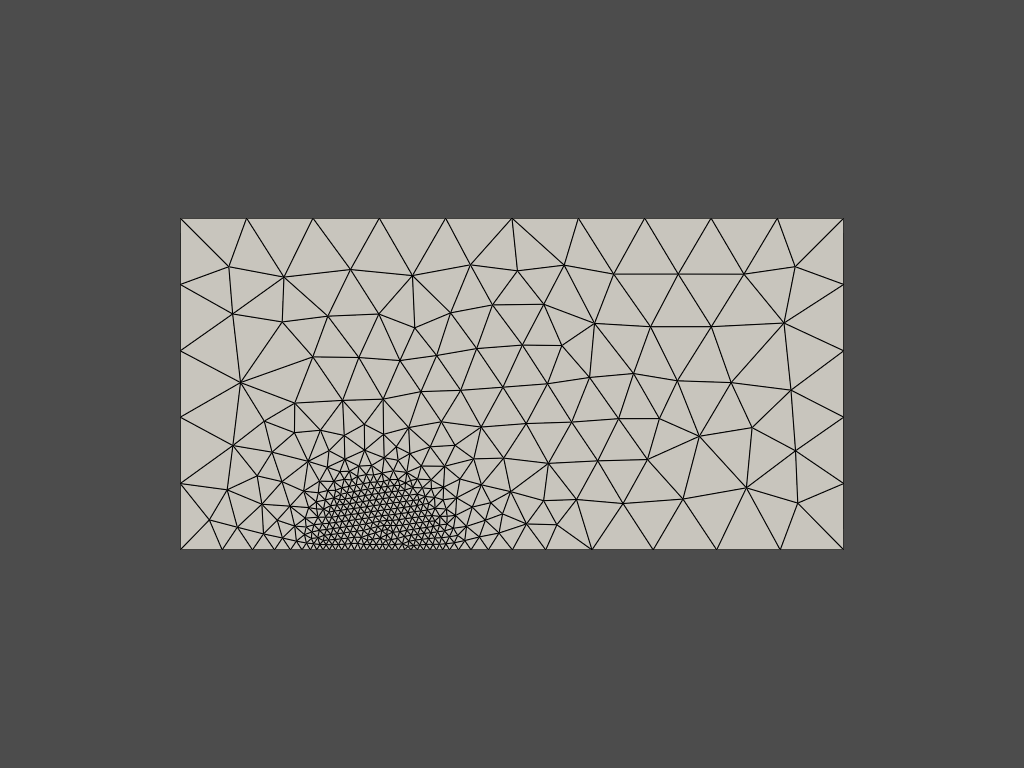

In [6]:
import pyvista

pyvista.set_jupyter_backend("none")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = dolfinx.plot.create_vtk_mesh(msh)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'

pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    plotter.screenshot("mesh.png")

We wrap the code to generate the mesh in the external modoule `../python/meshes` to reuse it in the following tutorials.
We can use it as follows:

In [7]:
sys.path.append("python")
from meshes import generate_mesh_with_crack

msh, mt, ft = generate_mesh_with_crack(
        Lcrack=Lcrack,
        Ly=0.5,
        lc=0.1,  # caracteristic length of the mesh
        refinement_ratio=10,  # how much it is refined at the tip zone
        dist_min=dist_min,  # radius of tip zone
        dist_max=dist_max,  # radius of the transition zone
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00228467s, CPU 0.002312s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00666387s, CPU 0.006641s)
Info    : 413 nodes 829 elements
